In [ ]:
import os
# Find the latest version of spark 3.0  from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.2.1'
spark_version = 'spark-3.2.2'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:10 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease [15.9 kB]
Get:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packa

In [ ]:
!wget https://jdbc.postgresql.org/download/postgresql-42.2.24.jar

--2022-08-10 02:13:17--  https://jdbc.postgresql.org/download/postgresql-42.2.24.jar
Resolving jdbc.postgresql.org (jdbc.postgresql.org)... 72.32.157.228, 2001:4800:3e1:1::228
Connecting to jdbc.postgresql.org (jdbc.postgresql.org)|72.32.157.228|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1006549 (983K) [application/java-archive]
Saving to: ‘postgresql-42.2.24.jar’

postgresql-42.2.24. 100%[===================>] 982.96K  --.-KB/s    in 0.08s   

2022-08-10 02:13:17 (11.4 MB/s) - ‘postgresql-42.2.24.jar’ saved [1006549/1006549]



In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import Row

# initiate Spark Session
spark = SparkSession.builder.appName("CloudML").config("spark.driver.extraClassPath","/content/postgresql-42.2.24.jar").getOrCreate()
spark

In [ ]:
#Load and import all the required dependencies
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud


import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
!pip install -q langdetect
from langdetect import detect_langs
from langdetect import detect
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import FreqDist
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


     |████████████████████████████████| 981 kB 5.3 MB/s 


## Load data from local drive

In [ ]:
# Load Review data
file_path ='Dataset/yelp_academic_dataset_review.csv'
review_df = pd.read_csv(file_path)
review_df.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0.0,0.0,0.0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5.0,1.0,0.0,1.0,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0,0.0,0.0,0.0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1.0,0.0,1.0,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,1.0,0.0,1.0,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15


In [ ]:
# Load Business data
file_path ='Dataset/yelp_academic_dataset_business.csv'
business_df = pd.read_csv(file_path)
business_df.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",NaN
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."


## Load data from RDS


In [ ]:
from getpass import getpass
password = getpass('Enter database password')
# Configure settings for RDS

jdbc_url="jdbc:postgresql://project-yelp.cbqnkf7nream.us-east-1.rds.amazonaws.com:5432/postgres"
config = {"user":"postgres",
          "password": password,
          "driver":"org.postgresql.Driver"}

In [ ]:
# Read tables from RDS
business = spark.read.jdbc(url=jdbc_url, table="business", properties=config)
review = spark.read.jdbc(url=jdbc_url, table="reviews", properties=config)

In [ ]:
business.printSchema()

In [ ]:
business.show()

In [ ]:
review.printSchema()

In [ ]:
review.show()

In [ ]:
# Convert PySpark DataFrame to Pandas DataFrame
business_df = business.toPandas()
review_df = review.toPandas()

## Load data from Google drive

In [ ]:
# read csv file from google drive into google colab:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
link_review = 'https://drive.google.com/file/d/1Nd6B-R-0SWscb3ZNfIYh6DELZt3veHku/view?usp=sharing'

import pandas as pd
 
# to get the id part of the file
id = link_review.split("/")[-2]

print(id)

1Nd6B-R-0SWscb3ZNfIYh6DELZt3veHku


In [ ]:
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('yelp_reviews_Italian_Restaurant_cleanimport.csv') 
 
review_df = pd.read_csv('yelp_reviews_Italian_Restaurant_cleanimport.csv')
review_df

,review_id,user_id,business_id,review_stars,text,date
0,FNXvn55vcpxyf7najE2vJA,1hfMnNQ7tl49puuAz-UJFw,xwSWtJcQkzTF6HNm_IMgcg,1,I took an 8 year old and a 14 year old for the...,2016-08-04 20:32:00
1,JppBfMoyid1t7pOAw65Yqw,e1T7iT5uXUw4D8UqUkadRQ,xwSWtJcQkzTF6HNm_IMgcg,2,The delivery would bring me the wrong pizza an...,2015-04-29 05:47:09
2,JEP_e5vAKDv5z0-IwS82Yw,SUAuGsOSKJqDnUmaFfM2IQ,uI15YInpDsGBUZcNfm_TfQ,4,I'm glad that Michael & Lucy found a way to op...,2015-10-17 01:24:19
3,M8Ugk0S5VVDWA6oCEN9stg,7yocFdBPk6F93SQ7ORSEUQ,uI15YInpDsGBUZcNfm_TfQ,5,For pick up tonight I ordered the margarita pi...,2017-08-08 01:31:04
4,c3qUUA4t9MxpGvBKR1_nAw,K0icmRlTPY-JPMB6a_vanw,lq7dE9c10OvRfd_edJoyMg,5,"Excellent Cioppino. Great service, friendly st...",2018-08-14 04:57:50
...,...,...,...,...,...,...
18264,t9gdT9Qhtgfs4mXapVutcg,4DyMRBKrokax6d8LCI3GAw,Qkg16mN-8QR66gjzg6gMyw,5,"Personally, I like Convivo because their menu ...",2019-01-15 22:22:51
18265,WSbA-C3O0NmpLw6TnE3jAw,XkIdd2k-E_0oNWdN9TYnDA,Qkg16mN-8QR66gjzg6gMyw,1,"I searched happy hour near me,and I was led to...",2019-10-13 00:42:45
18266,yhpNUVcsr15gDON1Gp4fBQ,83210-qORiXnpY8xumztQg,Qkg16mN-8QR66gjzg6gMyw,5,"Beautiful restaurant, great food, and excellen...",2021-11-09 03:17:22
18267,_mMR_CGJg_UcmQLqzhui9Q,3GJX4VoWhaX_KWgHKzSJJg,HrnSaz2f1WUEoAQQ6iD6gw,5,"I want to thank Faith, the front desk manager ...",2021-06-27 00:53:14


In [ ]:
link_business = 'https://drive.google.com/file/d/1F-KXPqdF0qZic3NaFG8rqGRWCkoviIrJ/view?usp=sharing'

# to get the id part of the file
id = link_business.split("/")[-2]

print(id) 

1F-KXPqdF0qZic3NaFG8rqGRWCkoviIrJ


In [ ]:
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('yelp_business_dataset_italian_restaurant_clean.csv') 
 
business_df = pd.read_csv('yelp_business_dataset_italian_restaurant_clean.csv')
business_df

,business_id,BusinessName,City,PostalCd,latitude,longitude,StarRating,NumReviews,Close-Open,Categories
0,xwSWtJcQkzTF6HNm_IMgcg,Rusty's Pizza Parlor,Goleta,93117,34.429043,-119.869362,2.5,94,1,"Chicken Wings, Salad, Restaurants, Pizza, Ital..."
1,V4lqQdll3_TAEtkrHDYbAA,Italia Pizza & Pasta,Goleta,93117,34.442760,-119.830669,3.5,24,0,"Italian, Pizza, Food, Restaurants, Beer, Wine ..."
2,j-lxie7nEh3UeUTpiqekkQ,Presto Pasta,Santa Barbara,93103,34.424278,-119.683301,3.0,8,0,"Italian, Restaurants"
3,uI15YInpDsGBUZcNfm_TfQ,Borrello's Pizza & Pastaria,Carpinteria,93013,34.406306,-119.547665,4.0,169,0,"Restaurants, French, Italian, Pizza"
4,lq7dE9c10OvRfd_edJoyMg,Due Lune Cucina,Santa Barbara,93101,34.412192,-119.689592,4.0,79,0,"Restaurants, Italian"
...,...,...,...,...,...,...,...,...,...,...
77,TYVln68leW7BYuVksFyB5A,Sevilla,Santa Barbara,93101,34.415593,-119.696034,4.0,12,0,"Italian, American (New), Tapas Bars, Latin Ame..."
78,54oLdsGU9B8HxFTqCCqV-A,Via Maestra 42,Santa Barbara,93105,34.440076,-119.736323,4.5,589,1,"Caterers, Italian, Restaurants, Delis, Event P..."
79,PgtqA056auCp5EbcZMbXPQ,Trattoria Mollie,Santa Barbara,93108,34.421398,-119.642391,3.5,204,0,"Food, Restaurants, Desserts, Wine Bars, Bars, ..."
80,Qkg16mN-8QR66gjzg6gMyw,Convivo Restaurant and Bar,Santa Barbara,93103,34.417321,-119.672226,4.0,445,1,"Bars, Mediterranean, Restaurants, Nightlife, M..."


## Preprocessing

In [ ]:
# Look at the shape of both dataframes
print("Review shape is :",review_df.shape)
print("Business shape is :",business_df.shape)

Review shape is : (18269, 6)
Business shape is : (82, 10)


In [ ]:
# review_df into clean_m_df. (Matt)
review_df.rename(columns = {'review_stars':'stars'}, inplace=True)

In [ ]:
clean_review_df = review_df.copy()
clean_review_df

,review_id,user_id,business_id,stars,text,date
0,FNXvn55vcpxyf7najE2vJA,1hfMnNQ7tl49puuAz-UJFw,xwSWtJcQkzTF6HNm_IMgcg,1,I took an 8 year old and a 14 year old for the...,2016-08-04 20:32:00
1,JppBfMoyid1t7pOAw65Yqw,e1T7iT5uXUw4D8UqUkadRQ,xwSWtJcQkzTF6HNm_IMgcg,2,The delivery would bring me the wrong pizza an...,2015-04-29 05:47:09
2,JEP_e5vAKDv5z0-IwS82Yw,SUAuGsOSKJqDnUmaFfM2IQ,uI15YInpDsGBUZcNfm_TfQ,4,I'm glad that Michael & Lucy found a way to op...,2015-10-17 01:24:19
3,M8Ugk0S5VVDWA6oCEN9stg,7yocFdBPk6F93SQ7ORSEUQ,uI15YInpDsGBUZcNfm_TfQ,5,For pick up tonight I ordered the margarita pi...,2017-08-08 01:31:04
4,c3qUUA4t9MxpGvBKR1_nAw,K0icmRlTPY-JPMB6a_vanw,lq7dE9c10OvRfd_edJoyMg,5,"Excellent Cioppino. Great service, friendly st...",2018-08-14 04:57:50
...,...,...,...,...,...,...
18264,t9gdT9Qhtgfs4mXapVutcg,4DyMRBKrokax6d8LCI3GAw,Qkg16mN-8QR66gjzg6gMyw,5,"Personally, I like Convivo because their menu ...",2019-01-15 22:22:51
18265,WSbA-C3O0NmpLw6TnE3jAw,XkIdd2k-E_0oNWdN9TYnDA,Qkg16mN-8QR66gjzg6gMyw,1,"I searched happy hour near me,and I was led to...",2019-10-13 00:42:45
18266,yhpNUVcsr15gDON1Gp4fBQ,83210-qORiXnpY8xumztQg,Qkg16mN-8QR66gjzg6gMyw,5,"Beautiful restaurant, great food, and excellen...",2021-11-09 03:17:22
18267,_mMR_CGJg_UcmQLqzhui9Q,3GJX4VoWhaX_KWgHKzSJJg,HrnSaz2f1WUEoAQQ6iD6gw,5,"I want to thank Faith, the front desk manager ...",2021-06-27 00:53:14


In [ ]:
# Add target Label
new_df = clean_review_df.copy()
# Custom encode of target variable = labels
new_df['labels'] =np.where(new_df['stars']> 3, "1","0")
new_df.head()


,review_id,user_id,business_id,stars,text,date,labels
0,FNXvn55vcpxyf7najE2vJA,1hfMnNQ7tl49puuAz-UJFw,xwSWtJcQkzTF6HNm_IMgcg,1,I took an 8 year old and a 14 year old for the...,2016-08-04 20:32:00,0
1,JppBfMoyid1t7pOAw65Yqw,e1T7iT5uXUw4D8UqUkadRQ,xwSWtJcQkzTF6HNm_IMgcg,2,The delivery would bring me the wrong pizza an...,2015-04-29 05:47:09,0
2,JEP_e5vAKDv5z0-IwS82Yw,SUAuGsOSKJqDnUmaFfM2IQ,uI15YInpDsGBUZcNfm_TfQ,4,I'm glad that Michael & Lucy found a way to op...,2015-10-17 01:24:19,1
3,M8Ugk0S5VVDWA6oCEN9stg,7yocFdBPk6F93SQ7ORSEUQ,uI15YInpDsGBUZcNfm_TfQ,5,For pick up tonight I ordered the margarita pi...,2017-08-08 01:31:04,1
4,c3qUUA4t9MxpGvBKR1_nAw,K0icmRlTPY-JPMB6a_vanw,lq7dE9c10OvRfd_edJoyMg,5,"Excellent Cioppino. Great service, friendly st...",2018-08-14 04:57:50,1


In [ ]:
new_df['labels'].describe()

count     18269
unique        2
top           1
freq      12553
Name: labels, dtype: object

In [ ]:
# Adding a new column to count text length
new_df['text_length'] = new_df['text'].apply(len)
new_df.head()

,review_id,user_id,business_id,stars,text,date,labels,text_length
0,FNXvn55vcpxyf7najE2vJA,1hfMnNQ7tl49puuAz-UJFw,xwSWtJcQkzTF6HNm_IMgcg,1,I took an 8 year old and a 14 year old for the...,2016-08-04 20:32:00,0,922
1,JppBfMoyid1t7pOAw65Yqw,e1T7iT5uXUw4D8UqUkadRQ,xwSWtJcQkzTF6HNm_IMgcg,2,The delivery would bring me the wrong pizza an...,2015-04-29 05:47:09,0,153
2,JEP_e5vAKDv5z0-IwS82Yw,SUAuGsOSKJqDnUmaFfM2IQ,uI15YInpDsGBUZcNfm_TfQ,4,I'm glad that Michael & Lucy found a way to op...,2015-10-17 01:24:19,1,825
3,M8Ugk0S5VVDWA6oCEN9stg,7yocFdBPk6F93SQ7ORSEUQ,uI15YInpDsGBUZcNfm_TfQ,5,For pick up tonight I ordered the margarita pi...,2017-08-08 01:31:04,1,197
4,c3qUUA4t9MxpGvBKR1_nAw,K0icmRlTPY-JPMB6a_vanw,lq7dE9c10OvRfd_edJoyMg,5,"Excellent Cioppino. Great service, friendly st...",2018-08-14 04:57:50,1,91


In [ ]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18269 entries, 0 to 18268
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   review_id    18269 non-null  object
 1   user_id      18269 non-null  object
 2   business_id  18269 non-null  object
 3   stars        18269 non-null  int64 
 4   text         18269 non-null  object
 5   date         18269 non-null  object
 6   labels       18269 non-null  object
 7   text_length  18269 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 1.1+ MB


In [ ]:
new_df.describe()

,stars,text_length
count,18269.000000,18269.000000
mean,3.840331,538.402649
std,1.416983,490.776188
min,1.000000,25.000000
25%,3.000000,221.000000
50%,4.000000,392.000000
75%,5.000000,683.000000
max,5.000000,5000.000000


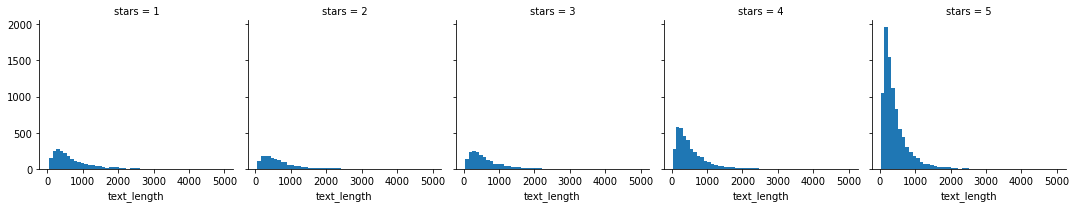

In [ ]:
# Visualizing the text_length with histograms for the various star ratings

g = sns.FacetGrid(data=new_df, col='stars')
g.map(plt.hist, 'text_length', bins=50)


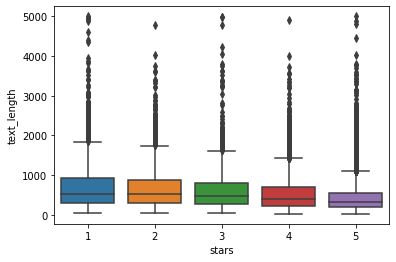

In [ ]:
# Another visualization of text_length using boxplot
sns.boxplot (x='stars', y='text_length', data=new_df)

In [ ]:
# Filter out reviews more than 2000 text lenght

new_df1 = new_df[new_df['text_length']<= 400]
print(new_df.shape)
print(new_df1.shape)

(18269, 8)
(9356, 8)


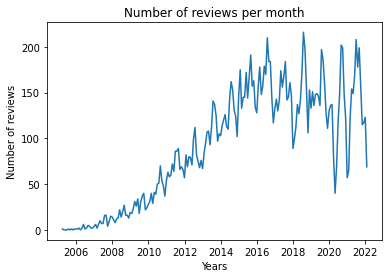

In [ ]:
# Creating a plot for number of reviews per month

# Converting 'date' with datetime
df= new_df.copy()
df['date'] = pd.to_datetime(df['date'])


df = df.set_index('date')
plt.plot(df['text'].resample('M').count())
plt.xlabel('Years')
plt.ylabel('Number of reviews')
plt.title('Number of reviews per month')

plt.show()


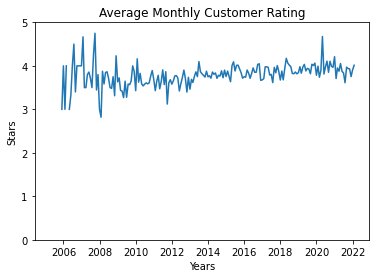

In [ ]:
# Creating a plot for average monthly customer rating
plt.plot(df['stars'].resample('M').mean())
plt.xlabel('Years')
plt.ylabel('Stars')
plt.title('Average Monthly Customer Rating')
plt.ylim(0,5)

plt.show()

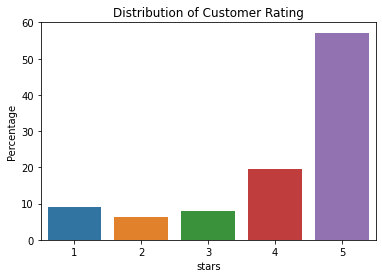

In [ ]:
# Exploring the distribution of customer ratings
ax = sns.barplot(data=new_df1, x='stars', y='stars', estimator=lambda x: len(x) / len(new_df1) * 100)
ax.set(ylabel="Percentage")
plt.title('Distribution of Customer Rating')

plt.show()

In [ ]:
new_df1.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 9356 entries, 1 to 18266
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   review_id    9356 non-null   object
 1   user_id      9356 non-null   object
 2   business_id  9356 non-null   object
 3   stars        9356 non-null   int64 
 4   text         9356 non-null   object
 5   date         9356 non-null   object
 6   labels       9356 non-null   object
 7   text_length  9356 non-null   int64 
dtypes: int64(2), object(6)
memory usage: 915.9+ KB


In [ ]:
# Check the language of the review texts
language = [detect_langs(i) for i in new_df1.text]
languages = [str(i[0]).split(':')[0] for i in language]
new_df1['language'] = languages
new_df1['language'].value_counts()

en       9315
pt         10
es          8
de          7
it          7
fr          4
zh-cn       1
ja          1
so          1
nl          1
tl          1
Name: language, dtype: int64

In [ ]:
# Filter out any other language other than English
filtered_df = new_df1[new_df1['language']== "en"]
print(filtered_df.shape)

(9315, 9)


In [ ]:
# Standard preprocessing of text reviews columm to get rid of other characters other than alphabets, convert to lowercase, remove stop words and reduce words to their base forms by lematization.

#made changes
stop_words = set(stopwords.words('english')) 

lm = WordNetLemmatizer()

def transform_text(feature):
    corpus = []
    for review in feature:
        content = re.sub('[^a-zA-Z]',' ',str(review))
        content = re.sub(r'[^\w\s]',' ',str(review))
        content = content.lower()
        content = content.split()
        content = [lm.lemmatize(word) for word in content if word not in stop_words]
        corpus.append(' '.join(str(x) for x in content))
    return corpus

corpus = transform_text(filtered_df['text'])

In [ ]:
# Adding cleaned text as a new column

#new code
filtered_df["text_clean"] = corpus
filtered_df.head()

,review_id,user_id,business_id,stars,text,date,labels,text_length,language,text_clean
1,JppBfMoyid1t7pOAw65Yqw,e1T7iT5uXUw4D8UqUkadRQ,xwSWtJcQkzTF6HNm_IMgcg,2,The delivery would bring me the wrong pizza an...,2015-04-29 05:47:09,0,153,en,delivery would bring wrong pizza course 2 topp...
3,M8Ugk0S5VVDWA6oCEN9stg,7yocFdBPk6F93SQ7ORSEUQ,uI15YInpDsGBUZcNfm_TfQ,5,For pick up tonight I ordered the margarita pi...,2017-08-08 01:31:04,1,197,en,pick tonight ordered margarita pizza added gar...
4,c3qUUA4t9MxpGvBKR1_nAw,K0icmRlTPY-JPMB6a_vanw,lq7dE9c10OvRfd_edJoyMg,5,"Excellent Cioppino. Great service, friendly st...",2018-08-14 04:57:50,1,91,en,excellent cioppino great service friendly staf...
5,5obXxR0b94b5q6j1zYCAzw,3inG_FUhm28tUJc0zZ2fCg,aY_n9RSaD2Yw09jSFFePew,1,We visited once and were very disappointed in ...,2017-08-16 15:43:19,0,315,en,visited disappointed veggie pizza husband sub ...
6,-Pg_rr4Xa_wcPaQfeMGDUA,BP2Hc1bdC_eNZ4Vrj4upNw,aY_n9RSaD2Yw09jSFFePew,5,So happy there is a family friendly place to w...,2016-09-18 21:37:34,1,117,en,happy family friendly place watch football car...


In [ ]:
print(corpus[:3])

['delivery would bring wrong pizza course 2 topping despise luck alwayscheckyourpizza whatsinthebox', 'pick tonight ordered margarita pizza added garlic mushroom ordered clam chowder favorite thin crust pizza crispy delicious', 'excellent cioppino great service friendly staff well located start stearns wharf']


In [ ]:
# Using lambda functions to find the polarity and subjectivity of each review
from textblob import TextBlob

pol = lambda x: TextBlob(x).sentiment.polarity
sub = lambda x: TextBlob(x).sentiment.subjectivity

filtered_df["polarity"] = filtered_df['text'].apply(pol)
filtered_df["subjectivity"] = filtered_df['text'].apply(sub)

filtered_df.head()

,review_id,user_id,business_id,stars,text,date,labels,text_length,language,text_clean,polarity,subjectivity
1,JppBfMoyid1t7pOAw65Yqw,e1T7iT5uXUw4D8UqUkadRQ,xwSWtJcQkzTF6HNm_IMgcg,2,The delivery would bring me the wrong pizza an...,2015-04-29 05:47:09,0,153,en,delivery would bring wrong pizza course 2 topp...,0.000000,0.700000
3,M8Ugk0S5VVDWA6oCEN9stg,7yocFdBPk6F93SQ7ORSEUQ,uI15YInpDsGBUZcNfm_TfQ,5,For pick up tonight I ordered the margarita pi...,2017-08-08 01:31:04,1,197,en,pick tonight ordered margarita pizza added gar...,0.366667,0.950000
4,c3qUUA4t9MxpGvBKR1_nAw,K0icmRlTPY-JPMB6a_vanw,lq7dE9c10OvRfd_edJoyMg,5,"Excellent Cioppino. Great service, friendly st...",2018-08-14 04:57:50,1,91,en,excellent cioppino great service friendly staf...,0.725000,0.750000
5,5obXxR0b94b5q6j1zYCAzw,3inG_FUhm28tUJc0zZ2fCg,aY_n9RSaD2Yw09jSFFePew,1,We visited once and were very disappointed in ...,2017-08-16 15:43:19,0,315,en,visited disappointed veggie pizza husband sub ...,-0.325000,0.491667
6,-Pg_rr4Xa_wcPaQfeMGDUA,BP2Hc1bdC_eNZ4Vrj4upNw,aY_n9RSaD2Yw09jSFFePew,5,So happy there is a family friendly place to w...,2016-09-18 21:37:34,1,117,en,happy family friendly place watch football car...,0.653750,0.770000


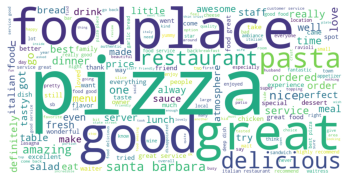

In [ ]:
# Word cloud after preprocessing
word_cloud = ""
for row in corpus:
    for word in row:
        word_cloud+=" ".join(word)
wordcloud = WordCloud(width = 1000, height = 500,background_color ='white',min_font_size = 10).generate(word_cloud)
plt.axis('off')
plt.imshow(wordcloud)

In [ ]:
# Tokenize corpus data 
word_tokens = word_tokenize(str(corpus))
tokens = list()
for word in word_tokens:
    if word.isalpha() and word not in stop_words:
        tokens.append(word)
token_dist = FreqDist(tokens)
dist = pd.DataFrame(token_dist.most_common(20),columns=['Word', 'Frequency'])

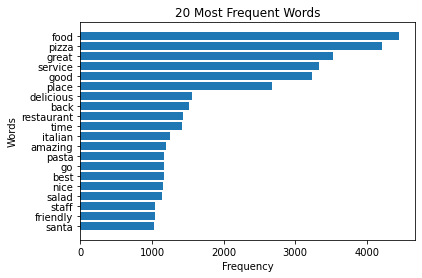

In [ ]:
# Visualize word frequency for unigram
dist.sort_values('Frequency',inplace=True)
y_axis = dist['Word']
x_axis = dist['Frequency']

plt.barh(y_axis,x_axis)
plt.title('20 Most Frequent Words')
plt.ylabel('Words')
plt.xlabel('Frequency')

plt.show()

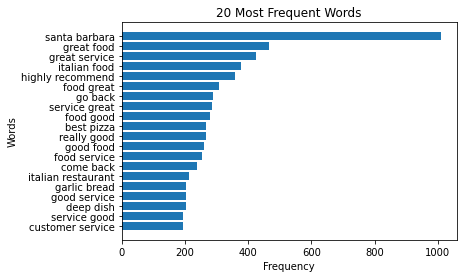

In [ ]:
# Visualize word frequency for bigram

CV = CountVectorizer(stop_words=stop_words, ngram_range=(2,2))
bigrams = CV.fit_transform(corpus)
bigram_df = pd.DataFrame(bigrams.toarray(), columns=CV.get_feature_names())
bigram_frequency = pd.DataFrame(bigram_df.sum(axis=0)).reset_index()
bigram_frequency.columns = ['bigram', 'frequency']
bigram_frequency = bigram_frequency.sort_values(by='frequency', ascending=False).head(20)

bigram_frequency .sort_values('frequency',inplace=True)
y_axis = bigram_frequency ['bigram']
x_axis = bigram_frequency ['frequency']

plt.barh(y_axis,x_axis)
plt.title('20 Most Frequent Words')
plt.ylabel('Words')
plt.xlabel('Frequency')

plt.show()

## Modelling

In [ ]:
# Vectorize the model to prepare the feature for modelling
cv = CountVectorizer(max_features = 1420)
traindata = cv.fit_transform(corpus).toarray()
X = traindata


# Define the vector of targets and matrix of features
y = filtered_df.labels


# Perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=42, stratify=y)

## Logistic Regression Model

In [ ]:
# Train and fit the model
log_reg = LogisticRegression().fit(X_train, y_train)
y_pred_lg = log_reg.predict(X_test)



In [ ]:
# Calculated the balanced accuracy score
balanced_accuracy_score(y_test, y_pred_lg)

0.864897794194316

In [ ]:
# Display the confusion matrix
cm = confusion_matrix(y_test, y_pred_lg)

# Create a DataFrame from the confusion matrix.
cm_df = pd.DataFrame(
    cm, index=["Actual Negative Review", "Actual Positive Review"], columns=["Predicted Negative Review", "Predicted Positive Review"])
cm_df

,Predicted Negative Review,Predicted Positive Review
Actual Negative Review,506,148
Actual Positive Review,94,2047


In [ ]:
# Print the classification report
print(classification_report(y_test, y_pred_lg))

              precision    recall  f1-score   support

           0       0.84      0.77      0.81       654
           1       0.93      0.96      0.94      2141

    accuracy                           0.91      2795
   macro avg       0.89      0.86      0.88      2795
weighted avg       0.91      0.91      0.91      2795



## Support vector machine (SVM)

In [ ]:
# Train and fit the model
model = SVC(kernel='linear')
model.fit(X_train, y_train)

SVC(kernel='linear')

In [ ]:
# Test model on test data
y_pred_svm = model.predict(X_test)
results = pd.DataFrame({
   "Prediction": y_pred_svm,
   "Actual": y_test
}).reset_index(drop=True)


In [ ]:
# Calculated the balanced accuracy score
balanced_accuracy_score(y_test, y_pred_svm)

0.8514141409813072

In [ ]:
# Display the confusion matrix
cm = confusion_matrix(y_test, y_pred_svm)

# Create a DataFrame from the confusion matrix.
cm_df = pd.DataFrame(
    cm, index=["Actual Negative Review", "Actual Positive Review"], columns=["Predicted Negative Review", "Predicted Positive Review"])
cm_df


,Predicted Negative Review,Predicted Positive Review
Actual Negative Review,496,158
Actual Positive Review,119,2022


In [ ]:
# Print the classification report
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

           0       0.81      0.76      0.78       654
           1       0.93      0.94      0.94      2141

    accuracy                           0.90      2795
   macro avg       0.87      0.85      0.86      2795
weighted avg       0.90      0.90      0.90      2795



## Multinomial Naive Bayes 

In [ ]:
# Creating the Multinomial Naive Bayes, designed more for text documents.
from sklearn.naive_bayes import MultinomialNB

Mnb_classifier = MultinomialNB()
# Fitting the model.
Mnb_model = Mnb_classifier.fit(X_train, y_train)

In [ ]:
# Making predictions using the testing data.
y_pred_Mnb = Mnb_model.predict(X_test)

In [ ]:
# Calculated the balanced accuracy score
balanced_accuracy_score(y_test, y_pred_Mnb)

0.8812110148877244

In [ ]:
# Display the confusion matrix
cm = confusion_matrix(y_test, y_pred_Mnb)

# Create a DataFrame from the confusion matrix.
cm_df = pd.DataFrame(
    cm, index=["Actual Negative Review", "Actual Positive Review"], columns=["Predicted Negative Review", "Predicted Positive Review"])
cm_df



,Predicted Negative Review,Predicted Positive Review
Actual Negative Review,542,112
Actual Positive Review,142,1999


In [ ]:
# Print the classification report
print(classification_report(y_test, y_pred_Mnb))

              precision    recall  f1-score   support

           0       0.79      0.83      0.81       654
           1       0.95      0.93      0.94      2141

    accuracy                           0.91      2795
   macro avg       0.87      0.88      0.88      2795
weighted avg       0.91      0.91      0.91      2795



## Random Forest Classifier Model

In [ ]:
# Create a random forest classifier.
rfc_model = RandomForestClassifier(n_estimators=128, random_state=78) 

# Fitting the model
rfc_model = rfc_model.fit(X_train, y_train)


y_pred_rfc = rfc_model.predict(X_test)

In [ ]:
# Calculated the balanced accuracy score
balanced_accuracy_score(y_test, y_pred_rfc)

0.8273696020751113

In [ ]:
# Display the confusion matrix
cm = confusion_matrix(y_test, y_pred_rfc)

# Create a DataFrame from the confusion matrix.
cm_df = pd.DataFrame(
    cm, index=["Actual Negative Review", "Actual Positive Review"], columns=["Predicted Negative Review", "Predicted Positive Review"])
cm_df




,Predicted Negative Review,Predicted Positive Review
Actual Negative Review,445,209
Actual Positive Review,55,2086


In [ ]:
# Print the classification report
print(classification_report(y_test, y_pred_rfc))

              precision    recall  f1-score   support

           0       0.89      0.68      0.77       654
           1       0.91      0.97      0.94      2141

    accuracy                           0.91      2795
   macro avg       0.90      0.83      0.86      2795
weighted avg       0.90      0.91      0.90      2795



## Balanced Random Forest Classifier Model

In [ ]:
# Balanced Random Forest Classifier Model
from imblearn.ensemble import BalancedRandomForestClassifier
brfc_model = BalancedRandomForestClassifier(n_estimators =100, random_state=1)
brfc_model.fit(X_train, y_train)


# Making predictions using the testing data.
y_pred_brfc = brfc_model.predict(X_test)

In [ ]:
# Calculated the balanced accuracy score
balanced_accuracy_score(y_test, y_pred_brfc)

0.8736764523137177

In [ ]:
# Display the confusion matrix
cm = confusion_matrix(y_test, y_pred_brfc)

# Create a DataFrame from the confusion matrix.
cm_df = pd.DataFrame(
    cm, index=["Actual Negative Review", "Actual Positive Review"], columns=["Predicted Negative Review", "Predicted Positive Review"])
cm_df

,Predicted Negative Review,Predicted Positive Review
Actual Negative Review,552,102
Actual Positive Review,207,1934


In [ ]:
# Print the classification report
print(classification_report(y_test, y_pred_brfc))

              precision    recall  f1-score   support

           0       0.73      0.84      0.78       654
           1       0.95      0.90      0.93      2141

    accuracy                           0.89      2795
   macro avg       0.84      0.87      0.85      2795
weighted avg       0.90      0.89      0.89      2795



## Model Output Test

In [ ]:
# Function to define what output results should be printed by the model
def review_check(input_statement):
    if input_statement == 0:
        print("Negative sentiment review statement.")
    elif input_statement == 1:
        print("Postive sentiment review statement.")
    else:
        print("Incorrect review syntax.")

In [ ]:
# Function to process input statement
def review_model_prediction(text):
    text = transform_text(text)
    transformed_text = cv.transform(text).toarray()
    prediction = log_reg.predict(transformed_text)
    review_check(int(prediction))

In [ ]:
review_1 = ["This restaurant is incredible, and has the best pasta carbonara and the best tiramisu I've had in my life. All the food is wonderful, though. The calamari is not fried. The bread served with dinner comes right out of the oven, and the tomatoes are the freshest I've tasted outside of my mom's own garden. This is great attention to detail.\n\nI can no longer eat at any other Italian restaurant without feeling slighted. This is the first place I want take out-of-town visitors I'm looking to impress.\n\nThe owner, Jon, is helpful, friendly, and really cares about providing a positive dining experience. He's spot on with his wine recommendations, and he organizes wine tasting events which you can find out about by joining the mailing list or Facebook page."]


In [ ]:
review_model_prediction(review_1)


Postive sentiment review statement.


## Exploratory Analysis

In [ ]:
# Filtering for negative reviews which are ratings from 1-3
negative_df = filtered_df[filtered_df['stars']<= 3]
print(negative_df.shape)

(2179, 12)


In [ ]:
negative_df

,review_id,user_id,business_id,stars,text,date,labels,text_length,language,text_clean,polarity,subjectivity
1,JppBfMoyid1t7pOAw65Yqw,e1T7iT5uXUw4D8UqUkadRQ,xwSWtJcQkzTF6HNm_IMgcg,2,The delivery would bring me the wrong pizza an...,2015-04-29 05:47:09,0,153,en,delivery would bring wrong pizza course 2 topp...,0.000000,0.700000
5,5obXxR0b94b5q6j1zYCAzw,3inG_FUhm28tUJc0zZ2fCg,aY_n9RSaD2Yw09jSFFePew,1,We visited once and were very disappointed in ...,2017-08-16 15:43:19,0,315,en,visited disappointed veggie pizza husband sub ...,-0.325000,0.491667
25,1brexj91F8QtNA1wO8y8Dg,3O5i-UsK6xFXP_IwbIR2Bw,aY_n9RSaD2Yw09jSFFePew,3,Average pizza. Nice garden salad. Was ok but w...,2018-05-29 04:14:57,0,122,en,average pizza nice garden salad ok nothing spe...,0.334524,0.636905
26,-25COkdN-SWHbFJSgTbKow,OkSaN1bdYc78YloND2NOcA,aY_n9RSaD2Yw09jSFFePew,2,Decent salad bar but served in ancient wooden ...,2017-04-08 03:19:20,0,211,en,decent salad bar served ancient wooden bowl pi...,0.238690,0.509524
33,YUQJOEgE4CImwlvKlVoK7Q,v7kbKx75xvgIA9rWAnFfPQ,S3QHy1sshUeZwXOYviVsXQ,1,"Yesterday, our breakfast experience was the lo...",2017-12-03 18:24:30,0,315,en,yesterday breakfast experience low point stay ...,0.022222,0.488889
...,...,...,...,...,...,...,...,...,...,...,...,...
18212,tDm7-FhvNx3KuBevG0dCNQ,YOM2MPXyXYINHBPXo_ulHg,Qkg16mN-8QR66gjzg6gMyw,1,"If you expect timely service, this isnt the pl...",2019-03-30 19:30:42,0,306,en,expect timely service isnt place ordered house...,0.200000,0.450000
18214,5ORYQaOsa9Ab3r566V5p9g,GHt9AfxXFIsFItEOxn2dNw,HrnSaz2f1WUEoAQQ6iD6gw,1,This place is dirtier than cheap motel. I was ...,2015-06-07 17:06:35,0,204,en,place dirtier cheap motel fooled picture self ...,-0.116667,0.483333
18224,p79DAaUVGUkqIpZIZhUz8g,OGxniOH-PdXbYRLT5dCRdQ,4D7QDfPOsSPfKxBi3gs_qQ,2,Not happy with our takeout order at all - was ...,2021-11-24 01:55:51,0,360,en,happy takeout order told arrive 20 minute got ...,-0.165657,0.724242
18256,pQjmP9CSsdhtYjsndv1oCw,ba-cX0j6jkRL7bEU_1OhUw,Qkg16mN-8QR66gjzg6gMyw,1,Ordered the prime rib and it was burnt. Overal...,2020-09-21 21:20:04,0,109,en,ordered prime rib burnt overall experience exp...,-0.366667,0.466667


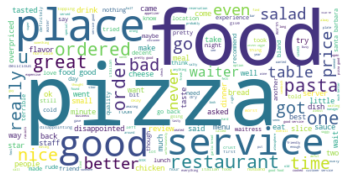

In [ ]:
# Wordcloud for negative reviews

# concatenate all the reviews into one single string 
full_text = ' '.join(negative_df['text_clean'])
cloud = WordCloud(background_color='white').generate(full_text)
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')

plt.show()

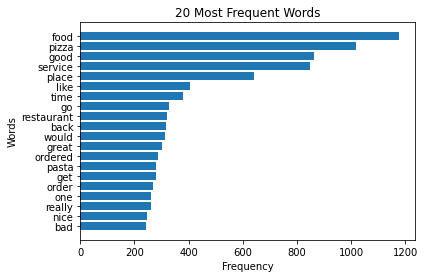

In [ ]:
# Visualize word frequency for negative reviews unigram

CV = CountVectorizer(stop_words=stop_words, ngram_range=(1,1))
unigrams = CV.fit_transform(negative_df["text_clean"])
unigram_df = pd.DataFrame(unigrams.toarray(), columns=CV.get_feature_names())
unigram_frequency = pd.DataFrame(unigram_df.sum(axis=0)).reset_index()
unigram_frequency.columns = ['unigram', 'frequency']
unigram_frequency = unigram_frequency.sort_values(by='frequency', ascending=False).head(20)

unigram_frequency .sort_values('frequency',inplace=True)
y_axis = unigram_frequency ['unigram']
x_axis = unigram_frequency ['frequency']

plt.barh(y_axis,x_axis)
plt.title('20 Most Frequent Words')
plt.ylabel('Words')
plt.xlabel('Frequency')

plt.show()

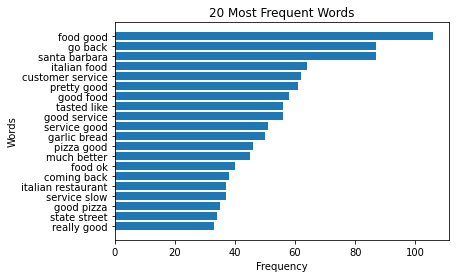

In [ ]:
# Visualize word frequency for negative reviews bigram

CV = CountVectorizer(stop_words=stop_words, ngram_range=(2,2))
bigrams = CV.fit_transform(negative_df["text_clean"])
bigram_df = pd.DataFrame(bigrams.toarray(), columns=CV.get_feature_names())
bigram_frequency = pd.DataFrame(bigram_df.sum(axis=0)).reset_index()
bigram_frequency.columns = ['bigram', 'frequency']
bigram_frequency = bigram_frequency.sort_values(by='frequency', ascending=False).head(20)

bigram_frequency .sort_values('frequency',inplace=True)
y_axis = bigram_frequency ['bigram']
x_axis = bigram_frequency ['frequency']

plt.barh(y_axis,x_axis)
plt.title('20 Most Frequent Words')
plt.ylabel('Words')
plt.xlabel('Frequency')

plt.show()

In [ ]:
# length measures for text data

filtered_df['word_count'] =filtered_df["text"].apply(lambda x: len(str(x).split(" ")))
filtered_df['char_count'] = filtered_df["text"].apply(lambda x: sum(len(word) for word in str(x).split(" ")))
filtered_df['sentence_count'] = filtered_df["text"].apply(lambda x: len(str(x).split(".")))
filtered_df['avg_word_length'] = filtered_df['char_count'] / filtered_df['word_count']
filtered_df['avg_sentence_lenght'] = filtered_df['word_count'] / filtered_df['sentence_count']
filtered_df.head()

,review_id,user_id,business_id,stars,text,date,labels,text_length,language,text_clean,polarity,subjectivity,word_count,char_count,sentence_count,avg_word_length,avg_sentence_lenght
1,JppBfMoyid1t7pOAw65Yqw,e1T7iT5uXUw4D8UqUkadRQ,xwSWtJcQkzTF6HNm_IMgcg,2,The delivery would bring me the wrong pizza an...,2015-04-29 05:47:09,0,153,en,delivery would bring wrong pizza course 2 topp...,0.000000,0.700000,25,129,3,5.160000,8.333333
3,M8Ugk0S5VVDWA6oCEN9stg,7yocFdBPk6F93SQ7ORSEUQ,uI15YInpDsGBUZcNfm_TfQ,5,For pick up tonight I ordered the margarita pi...,2017-08-08 01:31:04,1,197,en,pick tonight ordered margarita pizza added gar...,0.366667,0.950000,35,163,3,4.657143,11.666667
4,c3qUUA4t9MxpGvBKR1_nAw,K0icmRlTPY-JPMB6a_vanw,lq7dE9c10OvRfd_edJoyMg,5,"Excellent Cioppino. Great service, friendly st...",2018-08-14 04:57:50,1,91,en,excellent cioppino great service friendly staf...,0.725000,0.750000,14,78,4,5.571429,3.500000
5,5obXxR0b94b5q6j1zYCAzw,3inG_FUhm28tUJc0zZ2fCg,aY_n9RSaD2Yw09jSFFePew,1,We visited once and were very disappointed in ...,2017-08-16 15:43:19,0,315,en,visited disappointed veggie pizza husband sub ...,-0.325000,0.491667,63,253,5,4.015873,12.600000
6,-Pg_rr4Xa_wcPaQfeMGDUA,BP2Hc1bdC_eNZ4Vrj4upNw,aY_n9RSaD2Yw09jSFFePew,5,So happy there is a family friendly place to w...,2016-09-18 21:37:34,1,117,en,happy family friendly place watch football car...,0.653750,0.770000,19,99,2,5.210526,9.500000


In [ ]:
filtered_df["text"][:1]

1    The delivery would bring me the wrong pizza an...
Name: text, dtype: object